# Calculating Gene expression. 

This script calculates gene expression in raw read counts, RPKM and TPM (So we are looking at the raw reads and a normalizsed measure of gene expression) using matched samples of RNA-seq and ribosome profiling data. Note that in order to calculate these values properly, data outputted by the feature counts package is required. This is because Plastid appears to struggle to properly load the RNA data for Drosophilia melanogaster

### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary packages from Plastid

In [1]:
# Loading up required packages
from plastid import BAMGenomeArray, GenomeArray, GTF2_TranscriptAssembler, Transcript
from plastid.plotting.plots import *
import numpy as np
import pandas as pd
import copy
import setup_utils as st
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define important paths. 
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/"
feat_counts_path = "/home/keeganfl/Desktop/Work_Fall_2021/feature_counts/dmel/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/dmel/"
gtf_name = "Drosophila_melanogaster.BDGP6.32.103.gtf"
mutation = 'control'
samp_num = '3'
special = "fc"

### Step 4
Load in a GTF genome annotation file into python using Plastid's GTF2_TranscriptAssembler() function. This function will load in the transcripts as an iterator of transcript type objects which we will convert to a list.

In [3]:
# Load up the genome annotation as a list of transcript objects
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

### Step 5
Load in the Bam files containing the Ribosome Profiling data and the RNA sequencing data as a Bam Genome Array using Plastid's BamGenomeArray() function.

In [4]:
# Open the read alignments, storing each dataset in a BAMGenomeArray:
my_datasets = { "ribosome_profiling" : data_path + mutation +"_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam"}
my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

### Step 7
Create an empty dictionary in python that contains a list for each transcript in our GTF file and each metric we wish to calculate (e.g. length, number of counts, rpk).

In [5]:
# we will calculate both total counts and RPKM
metrics = ("counts","rpk","lengths")

# create an empty list for each sample and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs, gene_names, and gene_IDs.
my_data["transcript_ID"] = []
my_data["gene_name"] = []
my_data["gene_ID"] = []

### Step 8
Fill up the dictionary with the required metrics and then convert the dictionary to a pandas dataframe for easier organization. 

In [6]:
for transcript in gtf_reads:
        
    # First, save the ID of the transcript we are evaluating
    if transcript.attr["transcript_biotype"] == "protein_coding":
        my_data["transcript_ID"].append(transcript.get_name())
        my_data["gene_ID"].append(transcript.attr["gene_id"])
        my_data["gene_name"].append(transcript.attr["gene_name"])

        # Iterate over each sample
        for sample_name, sample_data in my_datasets.items():
            counts = sum(transcript.get_counts(sample_data))
            length = transcript.length
            rpk   = float(counts)/(length/1000)
            my_data["%s_counts" % (sample_name)].append(counts)
            my_data["%s_rpk"   % (sample_name)].append(rpk)
            my_data["%s_lengths" % (sample_name)].append(length)
            
# Convert to a Dataframe
df = pd.DataFrame(my_data)

## Loading RNA sequencing data from feature counts

In [7]:
# Load in feature counts data
feature_counts = pd.read_csv(feat_counts_path + 'counts_' + mutation + '_RNA_' + samp_num + '.txt', delimiter = "\t", comment='#')

In [8]:
# Select our columns of interest. 
cols = ["Geneid","Length",mutation + '_RNA_' + samp_num + "_Aligned.sortedByCoord.out.bam"]
feature_counts = feature_counts[cols]

In [9]:
# Rename our columns to assist with the merge to the dataframe. 
feature_counts.rename(columns = {mutation + '_RNA_' + samp_num + "_Aligned.sortedByCoord.out.bam" : "RNA-seq_counts",
                                "Length" : "RNA-seq_lengths", "Geneid" : "gene_ID"}, inplace = True)

In [10]:
# create new columns that contain the calculations for tpm and rpkm. 
feature_counts["RNA-seq_rpk"] = feature_counts["RNA-seq_counts"]/feature_counts["RNA-seq_lengths"]
feature_counts["RNA-seq_tpm"] = feature_counts["RNA-seq_rpk"]/(sum(feature_counts["RNA-seq_rpk"])/1e6)
feature_counts["RNA-seq_rpkm"] =feature_counts["RNA-seq_counts"]/ feature_counts["RNA-seq_lengths"]*1000 * 1e6 / sum(feature_counts["RNA-seq_counts"])

In [11]:
# Merging the table from feature counts with the plastid dataframe based on the gene names. 
df_merged = pd.merge(df,feature_counts, how = "inner", on = "gene_ID")
df = df_merged

### Step 9
Calculate RPKM and TPM for the ribo-profile and RNA-seq data for each transcript using the equations <br />
$
RPKM = 10^9 * \frac{reads\: mapped\: to\: the\: transcript}{total\: reads * transcript\: length}
$
<br />
&
<br />
$TPM = 10^6 * \frac{reads\: mapped\: to\: the\: transcript\:/\: transcript\: length }{Sum(reads\: mapped\: to\: each\: transcript\:/\: each\: transcript's\: length)}
$
<br />
Then add them as new columns to the pandas dataframe.

In [12]:
# Calculate tpm using rpk from our new dataframe. 
for sample_name in ["ribosome_profiling"]:
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s
    
# Calculate rpkm using the read counts.
for sample_name in ["ribosome_profiling"]:
    counts = df["%s_counts"   % (sample_name)]
    rpkm   = counts / df["ribosome_profiling_lengths"] * 1e9 / sum(counts)
    df["%s_rpkm" % (sample_name)] = rpkm

### Step 10
Calculate the TE by dividing the RPKM and TPM for the ribosome profiling data by the RPKM and TPM for the mRNA sequence data. Save the TE values as new columns in the pandas dataframe. 

In [13]:
# Calculate translation efficiency using tpm
df["TE_tpm"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

# Calculate translation efficiency using rpkm
df["TE_rpkm"] = df["ribosome_profiling_rpkm"] / df["RNA-seq_rpkm"]

In [14]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', "gene_ID","gene_name", 'TE_tpm','TE_rpkm','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk', 'ribosome_profiling_lengths', 'RNA-seq_lengths']
df = df[cols]

### Step 11
Use a kernel density estimate plot to look at the distribution of TE's in your data. This is an important step for making sure nothing has gone wrong in the alignment, P-site offsetting, or TE calculation steps. In order to create these TE tables, we are going to need to remove all of the negative or infinite values from our data (these occur naturally as a result of there being zero reads for genes that have very low expression). Once these annoying values have been removed we can use Plastids kde_plot() function to look at the distribution of TE values. We are hoping to see the majority of our TE values being somewhere between 0 and 5 with just a small proportion of transcripts having higher TEs than that. 

In [15]:
# We need to remove zeroes and infinite values in order to make the kernel density estimates
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]

# We are only going to look at TE values that fall within a certain region. 
df_interest=df_clean[(df_clean["TE_tpm"] >= 0)&(df_clean["TE_tpm"] <= 800)]

(0.0, 20.0)

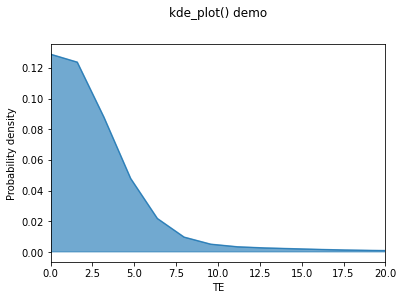

In [16]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_interest["TE_tpm"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)
plt.xlim(0,20)

### Step 12
save the dataframe using df.to_csv() so it can be used in future notebooks. 

In [17]:
# save the data frame.
df.to_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv", index = False)

In [18]:
df

,transcript_ID,gene_ID,gene_name,TE_tpm,TE_rpkm,ribosome_profiling_tpm,RNA-seq_tpm,ribosome_profiling_counts,RNA-seq_counts,ribosome_profiling_rpkm,RNA-seq_rpkm,ribosome_profiling_rpk,RNA-seq_rpk,ribosome_profiling_lengths,RNA-seq_lengths
0,FBtr0302344,FBgn0085506,CG40635,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,264,264
1,FBtr0300105,FBgn0259817,SteXh:CG42398,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,615,615
2,FBtr0347010,FBgn0085692,CG41561,inf,inf,0.363445,0.000000,2.040000,0,0.205685,0.000000,1.428571,0.000000,1428,1428
3,FBtr0078170,FBgn0002121,l(2)gl,0.154702,0.174019,26.022150,168.208107,536.785541,21635,14.726777,84.627492,102.283830,3.614267,5248,5986
4,FBtr0078171,FBgn0002121,l(2)gl,0.150599,0.169403,25.331894,168.208107,536.785541,21635,14.336139,84.627492,99.570681,3.614267,5391,5986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30705,FBtr0433500,FBgn0262952,mt:ND4,0.383245,0.431098,200.754140,523.827421,1056.595850,15071,113.613265,263.543784,789.093242,11.255414,1339,1339
30706,FBtr0100880,FBgn0013683,mt:ND4L,16.903132,19.013723,400.094556,23.669848,457.635224,148,226.426457,11.908581,1572.629636,0.508591,291,291
30707,FBtr0100883,FBgn0013685,mt:ND6,25.972058,29.215030,227.933936,8.776122,470.361869,99,128.995191,4.415371,895.927370,0.188571,525,525
30708,FBtr0433502,FBgn0013678,mt:Cyt-b,0.147568,0.165994,704.106463,4771.397699,3146.752668,116568,398.476634,2400.546733,2767.592496,102.522427,1137,1137


#samtools view -bo subset.bam -s 123.2 Fmr1_RPF_2_Aligned.sortedByCoord.out.bam
#this is just a command that will allow me to create subsets of the data to work on. I should see if there is a way to keep certain genes in this subset, it would be a shame if all of the mutant targets got lost in the subsetting. 